# Sentiment Analysis

In this notebook, we'll explore the emotions and themes of todays top hit songs.

### Imports

In [1]:
import re
import nltk
import spacy
import pandas as pd
import contractions
from nrclex import NRCLex
import matplotlib.pyplot as plt

# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger_eng')
nlp = spacy.load("en_core_web_sm")


In [2]:
df = pd.read_excel("../data/processed/hot100_translated.xlsx")

df.head()

,date,rank,title,artist,image,peakPos,lastpos,weeks,isNew,song_id,lyrics,orig_lang,lyrics_en
0,2024-12-28,1,All I Want For Christmas Is You,Mariah Carey,https://charts-static.billboard.com/img/1994/1...,1,1,70,False,all_i_want_for_christmas_is_you__mariah_carey,i don't want a lot for christmas there is just...,en,i don't want a lot for christmas there is just...
1,2024-12-28,2,Rockin' Around The Christmas Tree,Brenda Lee,https://charts-static.billboard.com/img/1960/1...,1,2,63,False,rockin_around_the_christmas_tree__brenda_lee,rockin' around the christmas tree at the chris...,en,rockin' around the christmas tree at the chris...
2,2024-12-28,3,Last Christmas,Wham!,https://charts-static.billboard.com/img/1998/0...,3,4,44,False,last_christmas__wham,"ah, ah-ah ooh-woah oh-oh last christmas, i gav...",en,"ah, ah-ah ooh-woah oh-oh last christmas, i gav..."
3,2024-12-28,4,Jingle Bell Rock,Bobby Helms,https://charts-static.billboard.com/img/1958/1...,3,3,60,False,jingle_bell_rock__bobby_helms,"jingle bell, jingle bell, jingle bell rock jin...",en,"jingle bell, jingle bell, jingle bell rock jin..."
4,2024-12-28,5,A Holly Jolly Christmas,Burl Ives,https://charts-static.billboard.com/img/1998/0...,4,5,44,False,a_holly_jolly_christmas__burl_ives,ding-dong-ding ding-dong-ding have a holly jol...,en,ding-dong-ding ding-dong-ding have a holly jol...


Filter only relevant songs

In [3]:
df = df[df["lyrics_en"].notna()]

,date,rank,title,artist,image,peakPos,lastpos,weeks,isNew,song_id,lyrics,orig_lang,lyrics_en
0,2024-12-28,1,All I Want For Christmas Is You,Mariah Carey,https://charts-static.billboard.com/img/1994/1...,1,1,70,False,all_i_want_for_christmas_is_you__mariah_carey,i don't want a lot for christmas there is just...,en,i don't want a lot for christmas there is just...
1,2024-12-28,2,Rockin' Around The Christmas Tree,Brenda Lee,https://charts-static.billboard.com/img/1960/1...,1,2,63,False,rockin_around_the_christmas_tree__brenda_lee,rockin' around the christmas tree at the chris...,en,rockin' around the christmas tree at the chris...
2,2024-12-28,3,Last Christmas,Wham!,https://charts-static.billboard.com/img/1998/0...,3,4,44,False,last_christmas__wham,"ah, ah-ah ooh-woah oh-oh last christmas, i gav...",en,"ah, ah-ah ooh-woah oh-oh last christmas, i gav..."
3,2024-12-28,4,Jingle Bell Rock,Bobby Helms,https://charts-static.billboard.com/img/1958/1...,3,3,60,False,jingle_bell_rock__bobby_helms,"jingle bell, jingle bell, jingle bell rock jin...",en,"jingle bell, jingle bell, jingle bell rock jin..."
4,2024-12-28,5,A Holly Jolly Christmas,Burl Ives,https://charts-static.billboard.com/img/1998/0...,4,5,44,False,a_holly_jolly_christmas__burl_ives,ding-dong-ding ding-dong-ding have a holly jol...,en,ding-dong-ding ding-dong-ding have a holly jol...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,2024-01-06,43,I Saw Mommy Kissing Santa Claus,Jackson 5,https://charts-static.billboard.com/img/1969/1...,43,0,1,True,i_saw_mommy_kissing_santa_claus__jackson_5,wow! mommy's kissing santa claus! i saw mommy ...,en,wow! mommy's kissing santa claus! i saw mommy ...
754,2024-01-06,46,Merry Christmas,Ed Sheeran & Elton John,https://charts-static.billboard.com/img/2021/1...,42,0,7,False,merry_christmas__ed_sheeran__elton_john,build the fire and gather 'round the tree fill...,en,build the fire and gather 'round the tree fill...
755,2024-01-06,50,(There's No Place Like) Home For The Holidays ...,Perry Como With Mitchell Ayers And His Orchestra,https://charts-static.billboard.com/img/2005/1...,50,0,1,True,theres_no_place_like_home_for_the_holidays_195...,"oh, there's no place like home for the holiday...",en,"oh, there's no place like home for the holiday..."
756,2024-01-06,87,Winter Wonderland,Chloe,https://charts-static.billboard.com/img/2023/1...,87,96,2,False,winter_wonderland__chloe,"walk walk, walk, walking walk, walk, walking w...",en,"walk walk, walk, walking walk, walk, walking w..."


### Preprocess helpers

In [26]:
def clean(text):

    # preprocess
    text = re.sub(r'[^a-z0-9\s\.\,\!\?]', '', text)
    text = re.sub(r'\s+', " ", text).strip()
    text = contractions.fix(text)

    # lemmatize and re-concatinate
    doc = nlp(text)
    lemmas = [tok.lemma_ for tok in doc]
    cleaned = " ".join(lemmas)

    return cleaned

def detect_emotions(text):
    text = clean(text)
    emotions = NRCLex(text)
    return emotions.raw_emotion_scores


# Normalize emotion and sentiment scores separately

def normalize_raw_emotions(emotions):
    pol = ["positive","negative"]
    core = [key for key in emotions.keys() if key not in pol]
    total_core = sum(emotions[e] for e in core)
    core_dist = { e: emotions[e] / total_core 
              for e in core }
    return core_dist

def normalize_sentiment(emotions):
    pol = ["positive","negative"]
    pol = [key for key in emotions.keys() if key in pol]
    total_pol = sum(emotions[e] for e in pol)
    pol_dist = { p: emotions[p] / total_pol for p in pol }

    return pol_dist

### Emotion Detection

For each song, we'll find the emotion and sentiment distributions

In [11]:
df["e_dict"] = df["lyrics_en"].apply(detect_emotions)
df["emotions"] = df["e_dict"].apply(normalize_raw_emotions)
df["sentiment"] = df["e_dict"].apply(normalize_sentiment)

df

,date,rank,title,artist,image,peakPos,lastpos,weeks,isNew,song_id,lyrics,orig_lang,lyrics_en,emotions,e_dict,sentiment
0,2024-12-28,1,All I Want For Christmas Is You,Mariah Carey,https://charts-static.billboard.com/img/1994/1...,1,1,70,False,all_i_want_for_christmas_is_you__mariah_carey,i don't want a lot for christmas there is just...,en,i don't want a lot for christmas there is just...,"{'anticipation': 0.16, 'joy': 0.44, 'surprise'...","{'anticipation': 8, 'joy': 22, 'positive': 23,...","{'positive': 0.9583333333333334, 'negative': 0..."
1,2024-12-28,2,Rockin' Around The Christmas Tree,Brenda Lee,https://charts-static.billboard.com/img/1960/1...,1,2,63,False,rockin_around_the_christmas_tree__brenda_lee,rockin' around the christmas tree at the chris...,en,rockin' around the christmas tree at the chris...,"{'anger': 0.11538461538461539, 'anticipation':...","{'anger': 6, 'anticipation': 10, 'disgust': 6,...","{'positive': 0.875, 'negative': 0.125}"
2,2024-12-28,3,Last Christmas,Wham!,https://charts-static.billboard.com/img/1998/0...,3,4,44,False,last_christmas__wham,"ah, ah-ah ooh-woah oh-oh last christmas, i gav...",en,"ah, ah-ah ooh-woah oh-oh last christmas, i gav...","{'joy': 0.23015873015873015, 'trust': 0.103174...","{'joy': 29, 'positive': 31, 'trust': 13, 'ange...","{'positive': 0.5849056603773585, 'negative': 0..."
3,2024-12-28,4,Jingle Bell Rock,Bobby Helms,https://charts-static.billboard.com/img/1958/1...,3,3,60,False,jingle_bell_rock__bobby_helms,"jingle bell, jingle bell, jingle bell rock jin...",en,"jingle bell, jingle bell, jingle bell rock jin...","{'anticipation': 0.8125, 'joy': 0.0625, 'trust...","{'positive': 10, 'anticipation': 13, 'joy': 1,...",{'positive': 1.0}
4,2024-12-28,5,A Holly Jolly Christmas,Burl Ives,https://charts-static.billboard.com/img/1998/0...,4,5,44,False,a_holly_jolly_christmas__burl_ives,ding-dong-ding ding-dong-ding have a holly jol...,en,ding-dong-ding ding-dong-ding have a holly jol...,"{'anticipation': 0.3, 'joy': 0.233333333333333...","{'anticipation': 9, 'joy': 7, 'positive': 7, '...","{'positive': 0.6363636363636364, 'negative': 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,2024-01-06,43,I Saw Mommy Kissing Santa Claus,Jackson 5,https://charts-static.billboard.com/img/1969/1...,43,0,1,True,i_saw_mommy_kissing_santa_claus__jackson_5,wow! mommy's kissing santa claus! i saw mommy ...,en,wow! mommy's kissing santa claus! i saw mommy ...,"{'anticipation': 0.2682926829268293, 'joy': 0....","{'anticipation': 11, 'joy': 14, 'positive': 14...","{'positive': 0.9333333333333333, 'negative': 0..."
754,2024-01-06,46,Merry Christmas,Ed Sheeran & Elton John,https://charts-static.billboard.com/img/2021/1...,42,0,7,False,merry_christmas__ed_sheeran__elton_john,build the fire and gather 'round the tree fill...,en,build the fire and gather 'round the tree fill...,"{'fear': 0.07692307692307693, 'anger': 0.01923...","{'positive': 38, 'fear': 8, 'anger': 2, 'antic...","{'positive': 0.926829268292683, 'negative': 0...."
755,2024-01-06,50,(There's No Place Like) Home For The Holidays ...,Perry Como With Mitchell Ayers And His Orchestra,https://charts-static.billboard.com/img/2005/1...,50,0,1,True,theres_no_place_like_home_for_the_holidays_195...,"oh, there's no place like home for the holiday...",en,"oh, there's no place like home for the holiday...","{'anticipation': 0.32142857142857145, 'joy': 0...","{'anticipation': 18, 'joy': 20, 'positive': 22...","{'positive': 0.9166666666666666, 'negative': 0..."
756,2024-01-06,87,Winter Wonderland,Chloe,https://charts-static.billboard.com/img/2023/1...,87,96,2,False,winter_wonderland__chloe,"walk walk, walk, walking walk, walk, walking w...",en,"walk walk, walk, walking walk, walk, walking w...","{'joy': 0.28125, 'anticipation': 0.21875, 'tru...","{'joy': 9, 'positive': 14, 'anticipation': 7, ...","{'positive': 0.7777777777777778, 'negative': 0..."


Let's plot some songs to see how it looks like

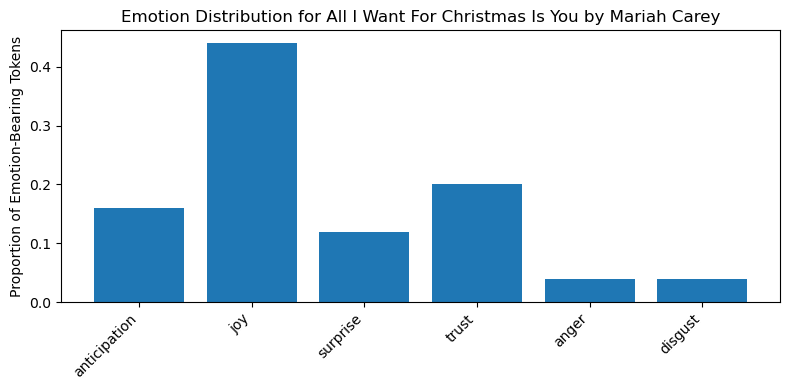

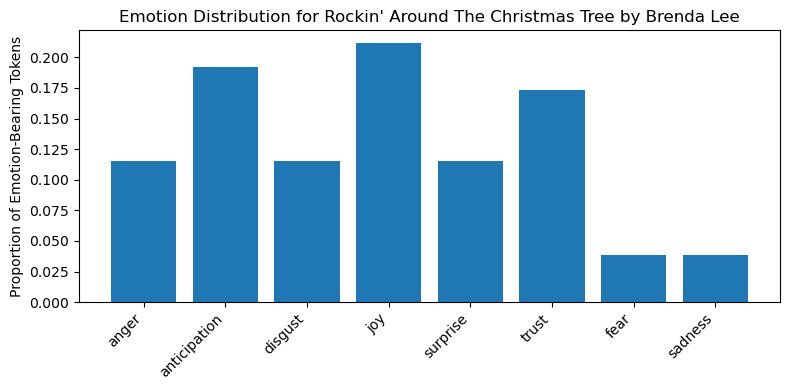

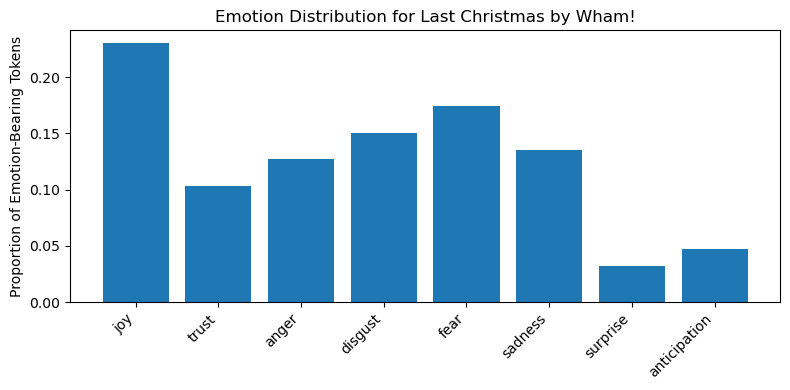

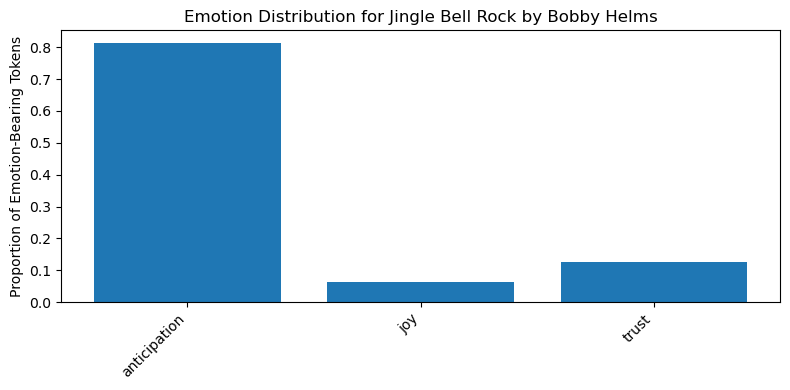

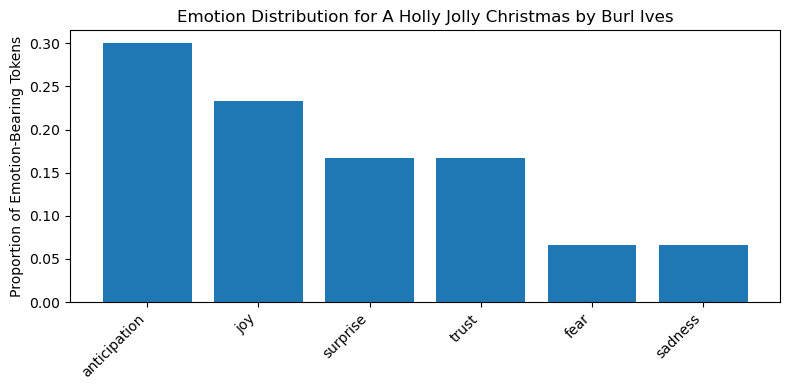

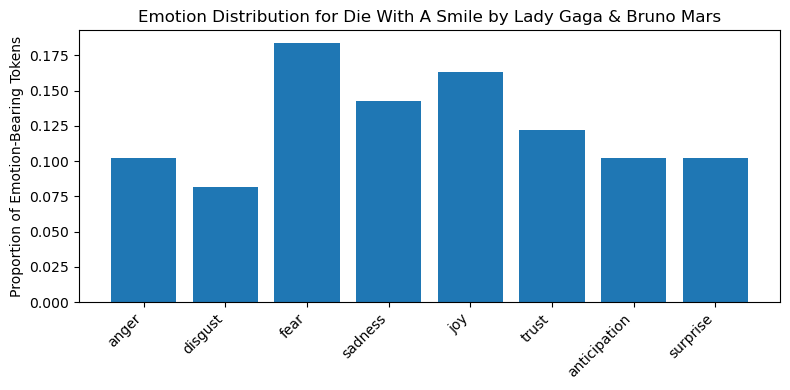

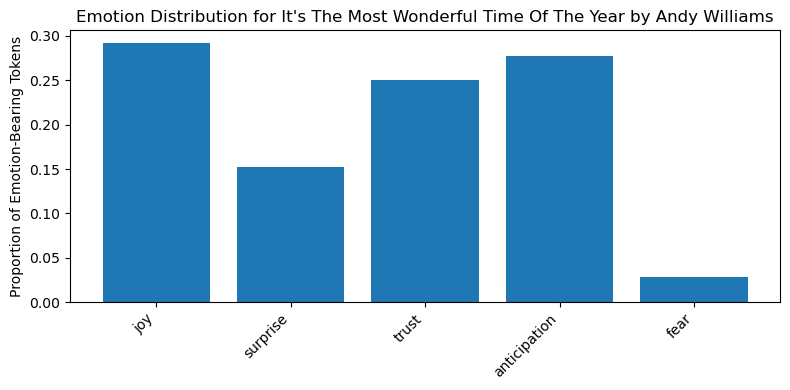

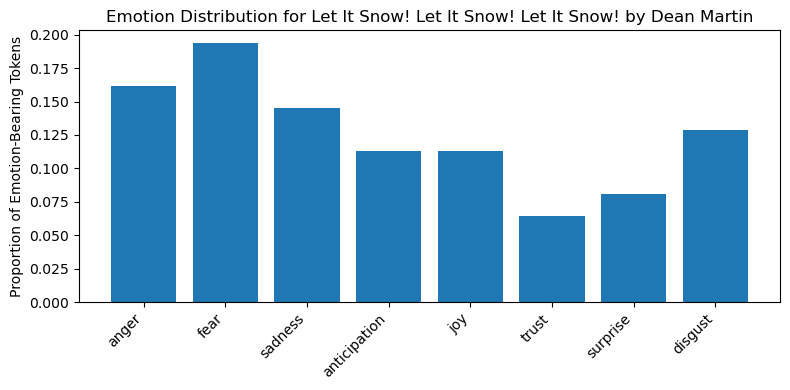

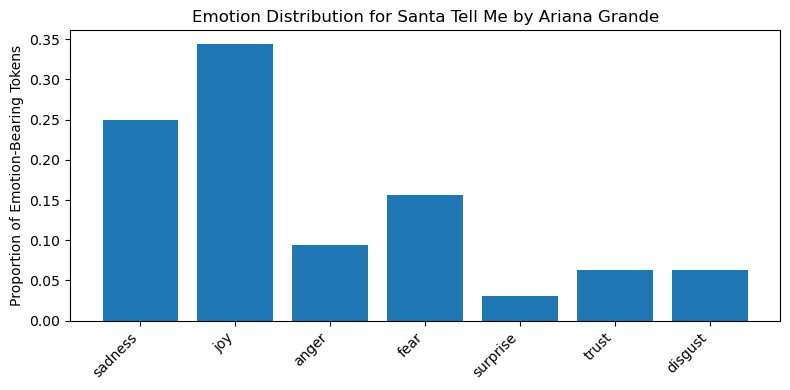

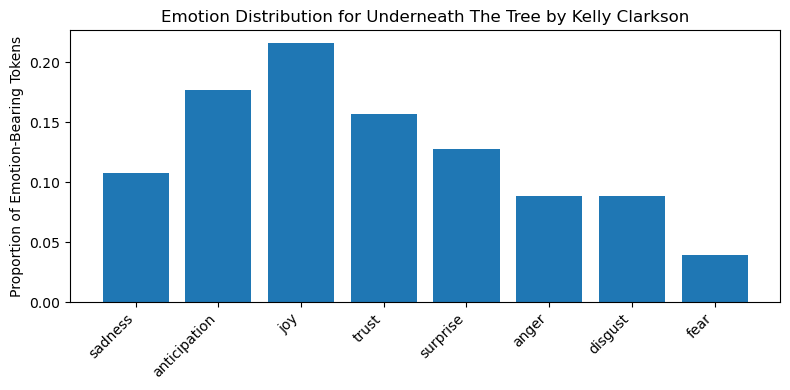

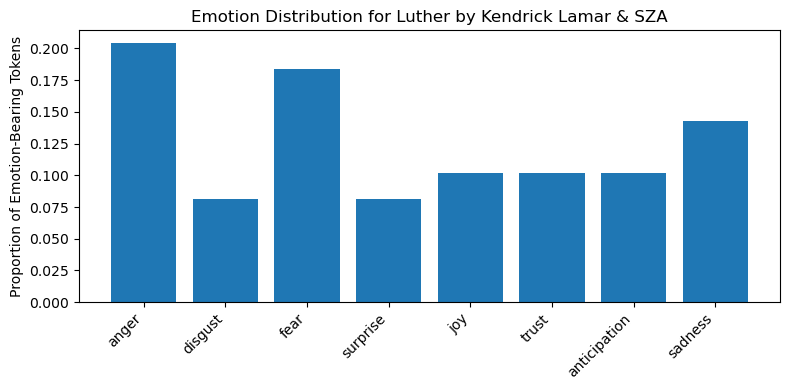

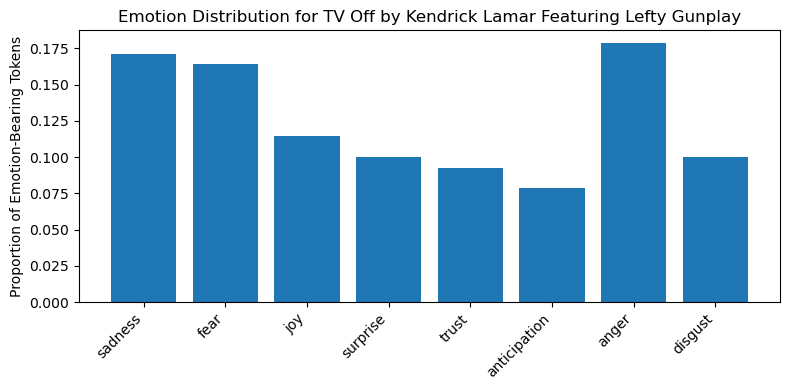

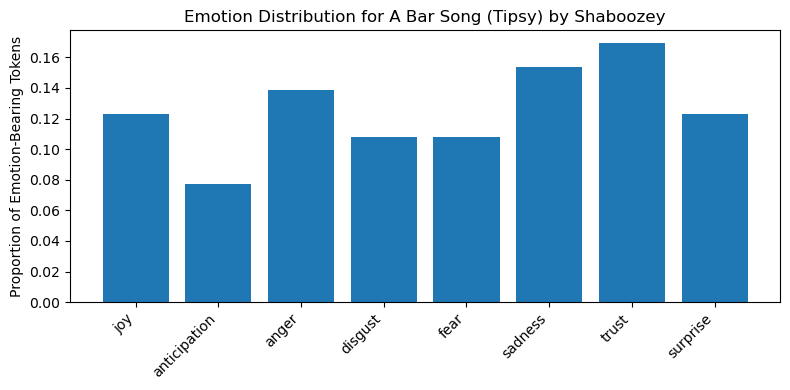

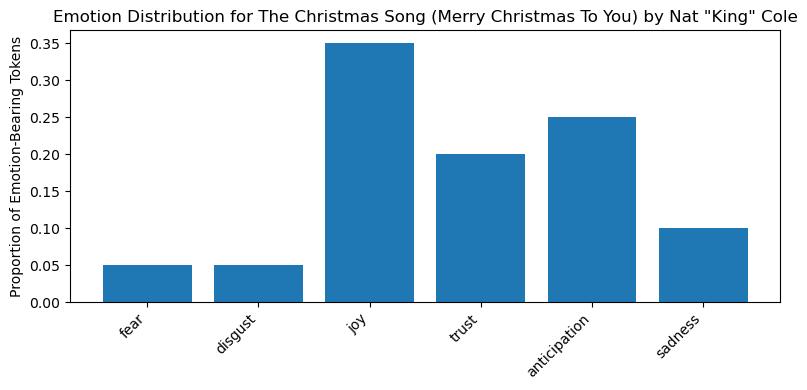

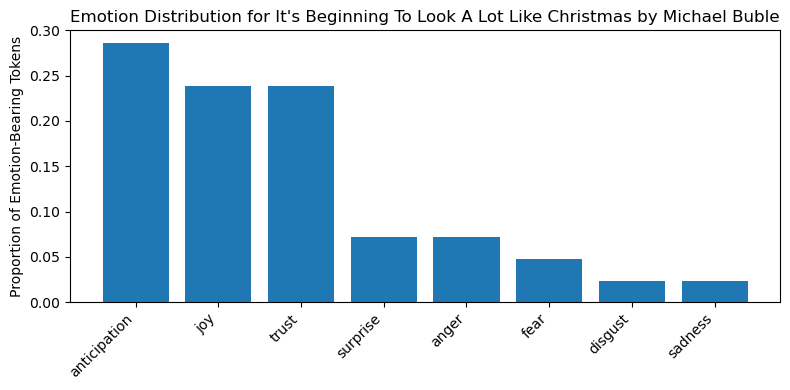

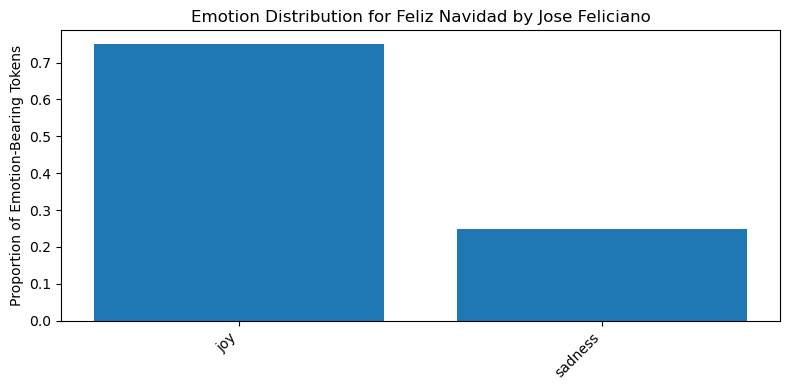

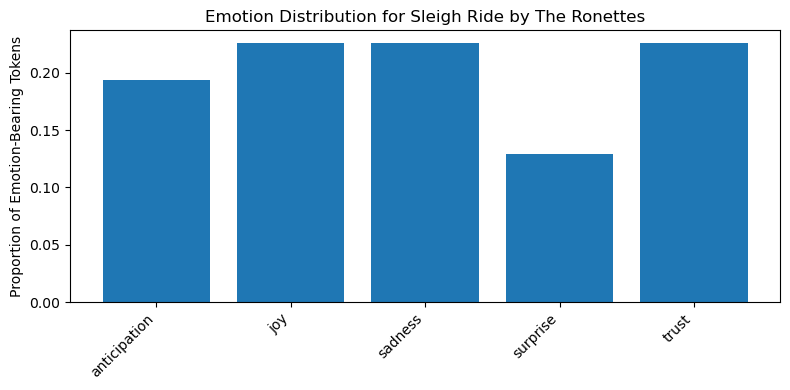

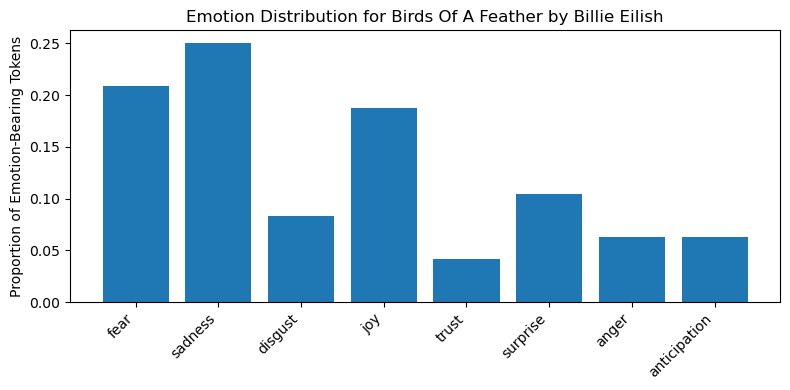

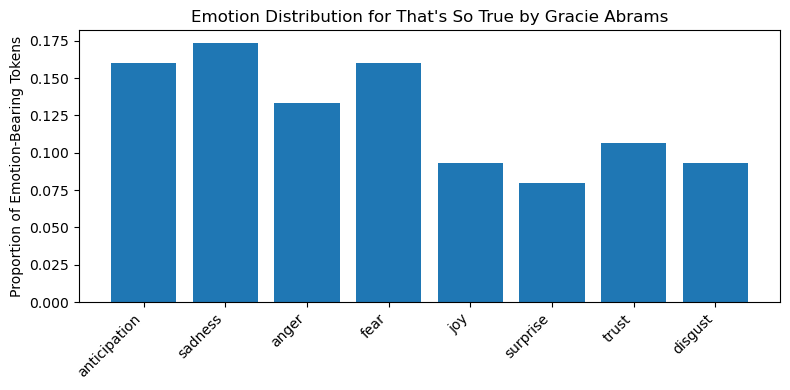

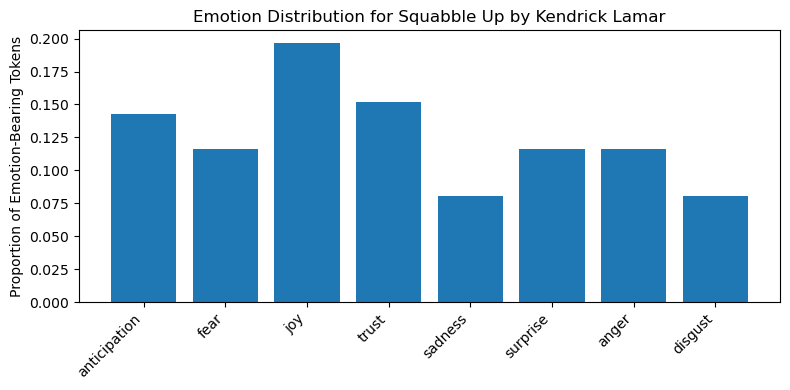

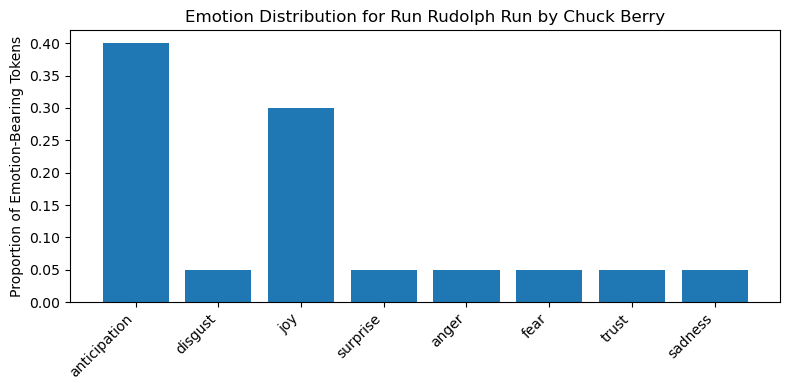

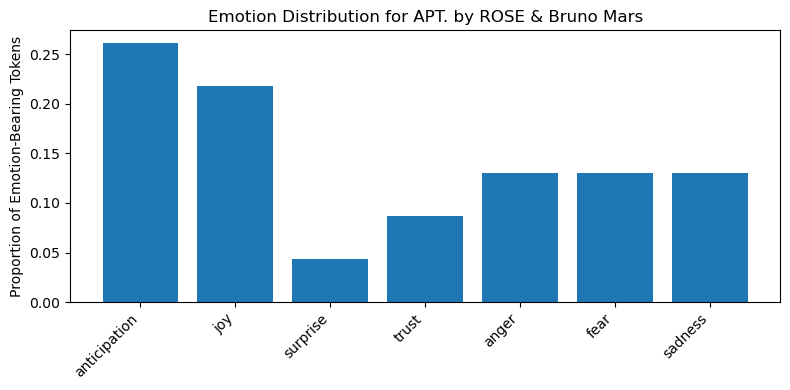

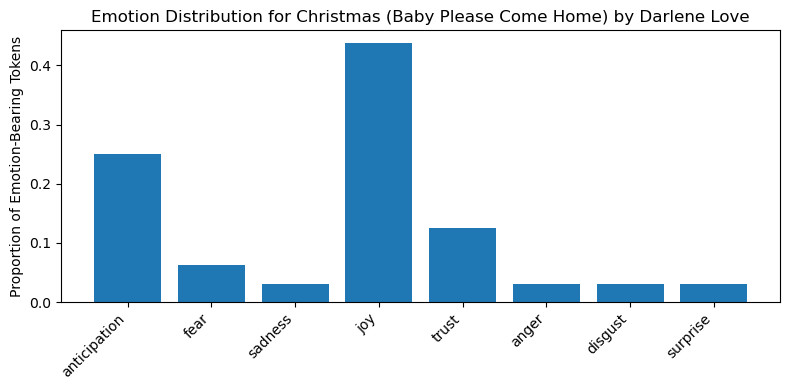

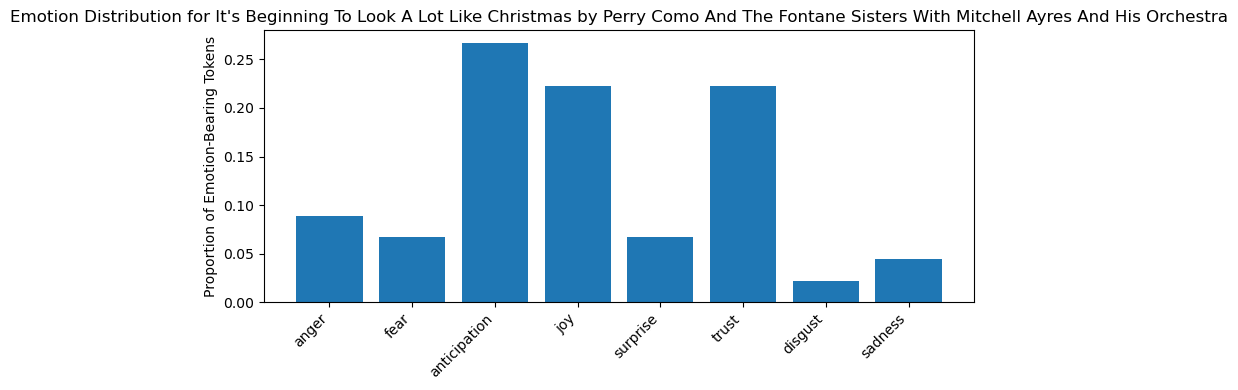

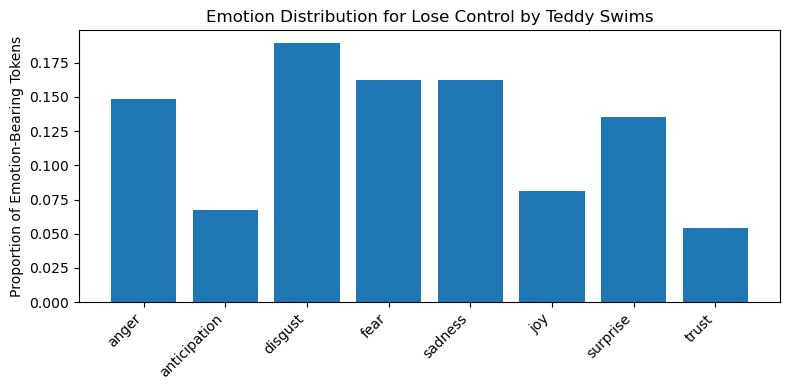

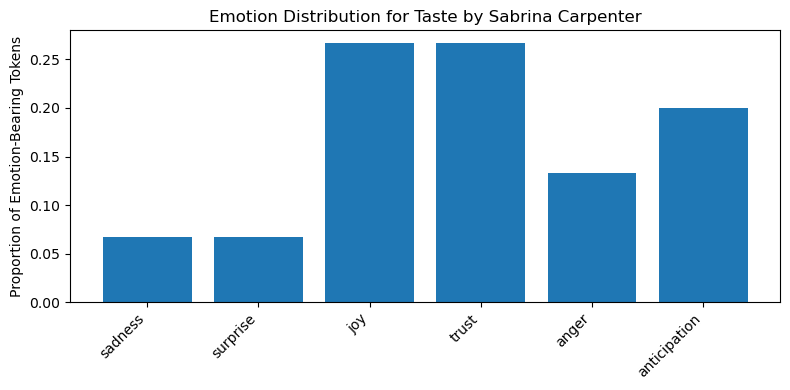

In [12]:
for idx, row in df.iterrows():

    if idx > 25: break
    
    emotions = row['emotions']
    keys = list(emotions.keys())
    values = [emotions[e] for e in keys]

    plt.figure(figsize=(8, 4))
    plt.bar(keys, values)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Proportion of Emotion-Bearing Tokens")
    plt.title(f"Emotion Distribution for {row['title']} by {row['artist']}")
    plt.tight_layout()
    plt.show()

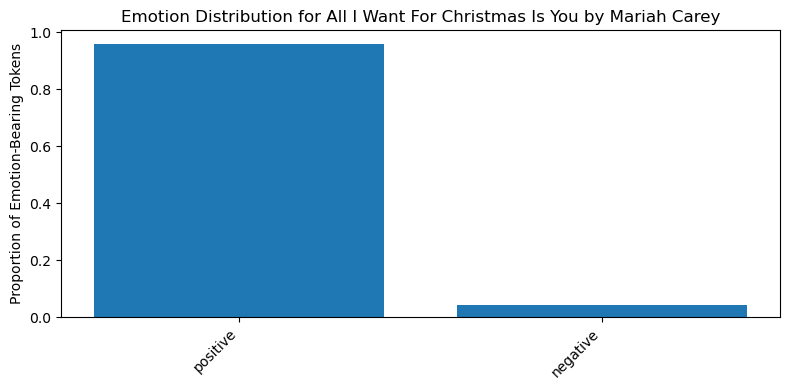

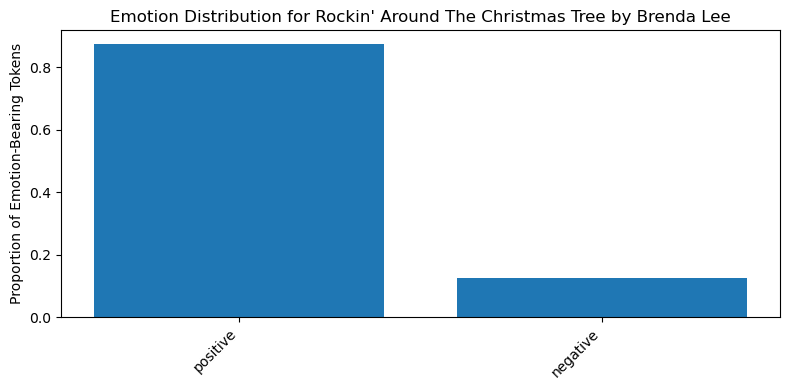

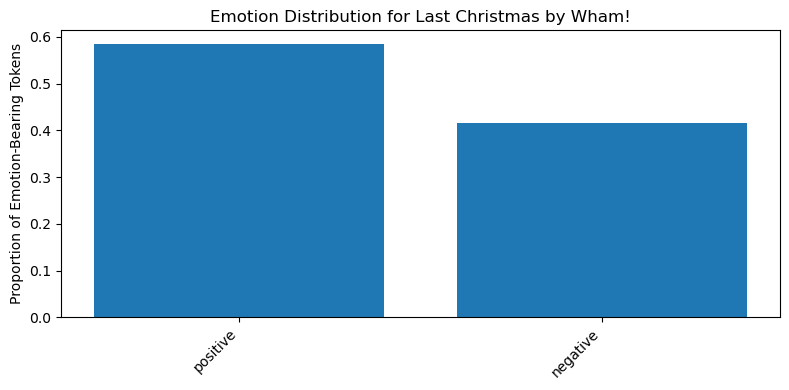

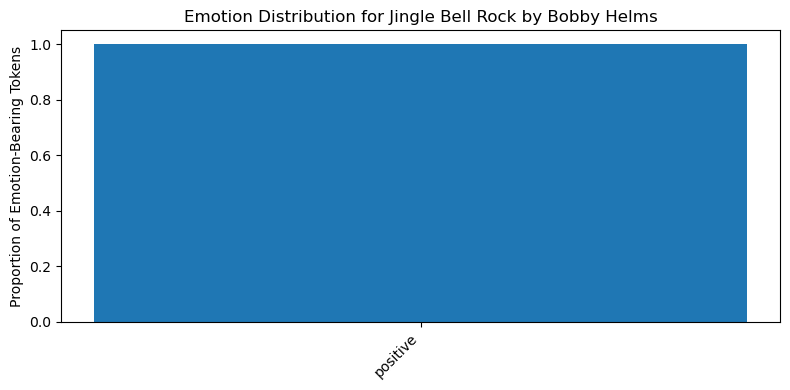

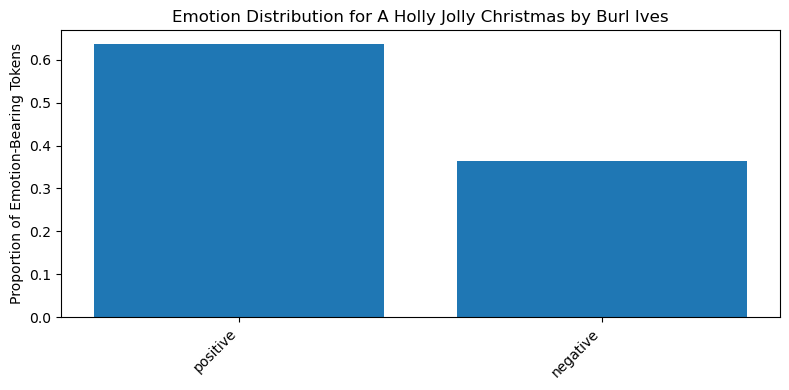

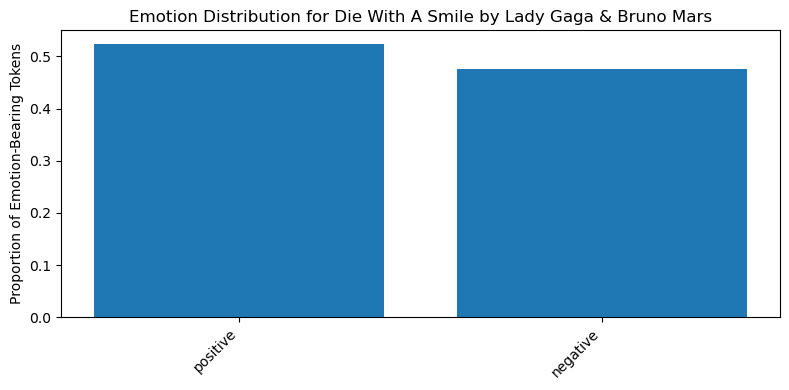

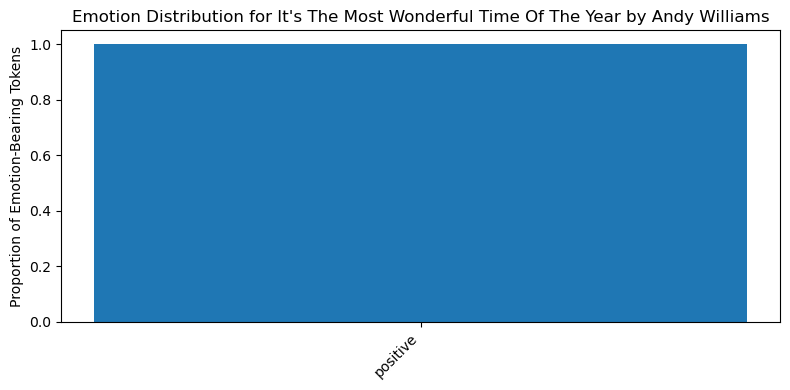

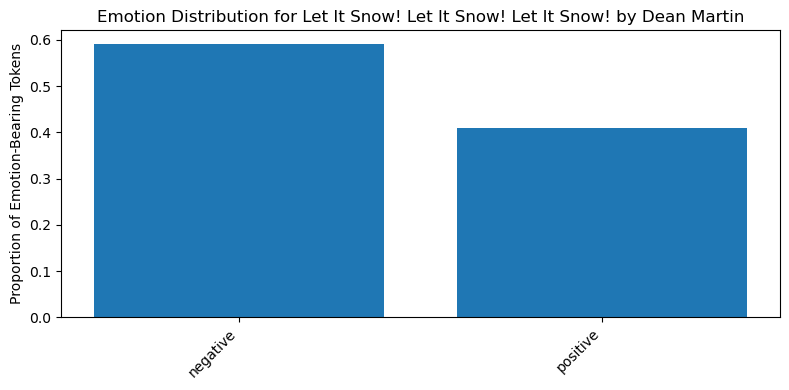

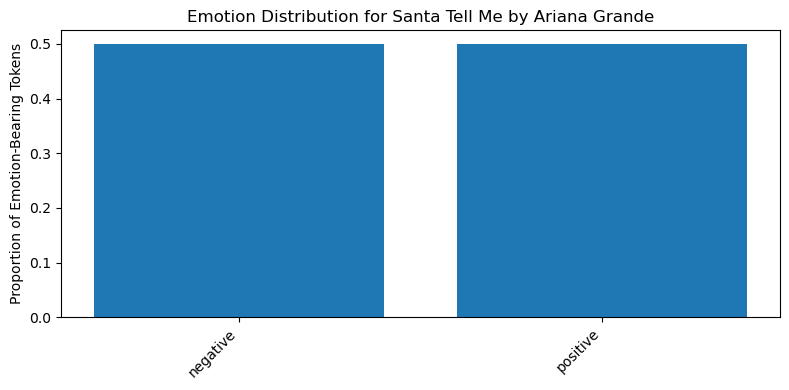

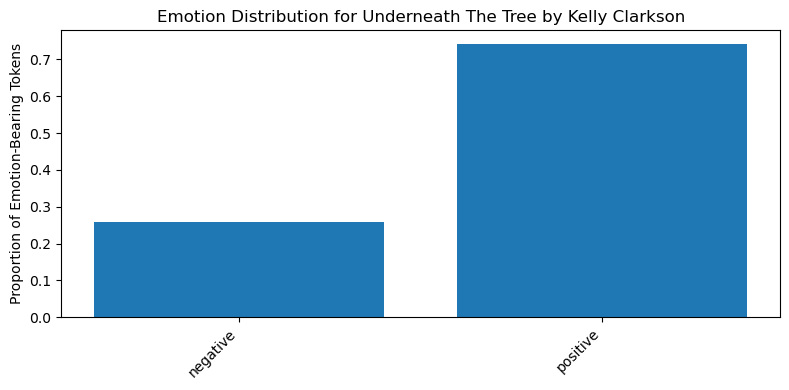

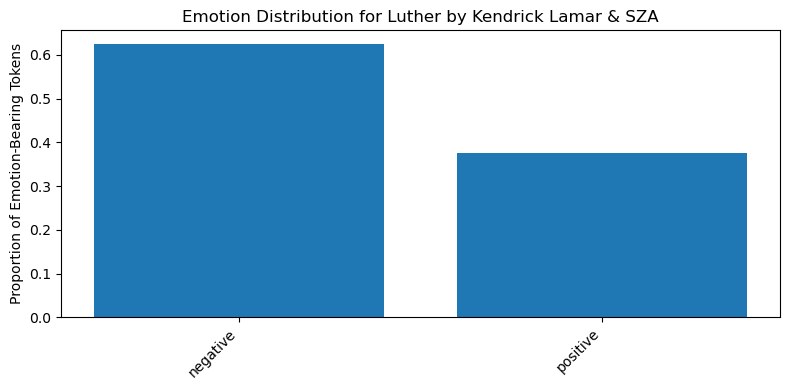

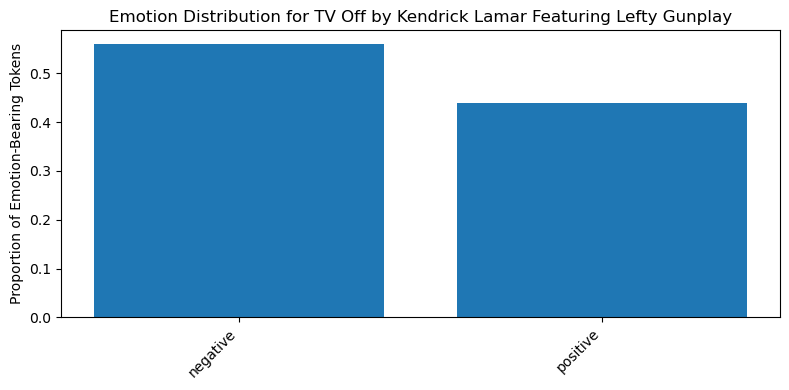

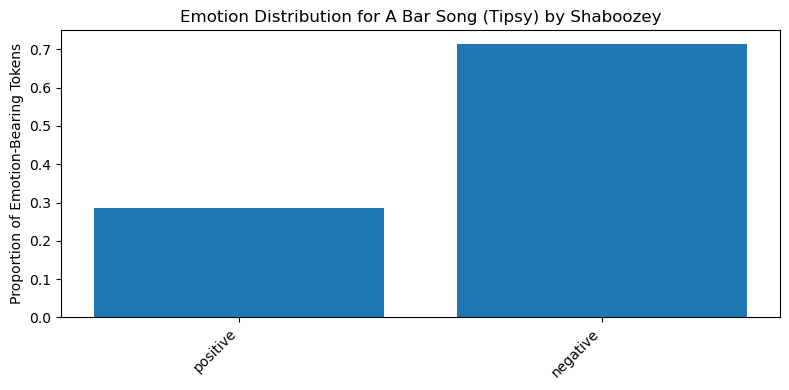

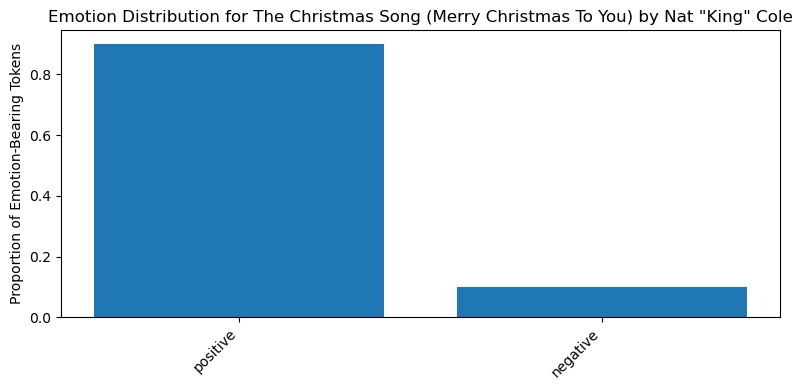

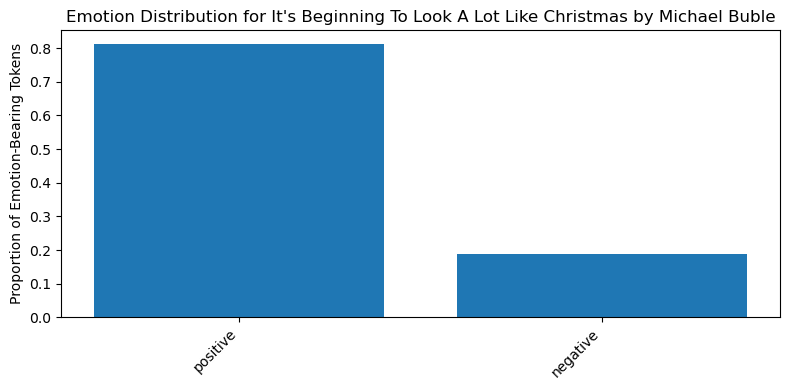

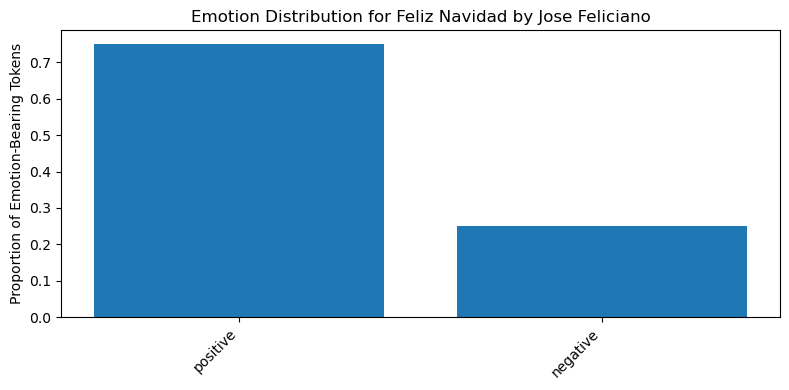

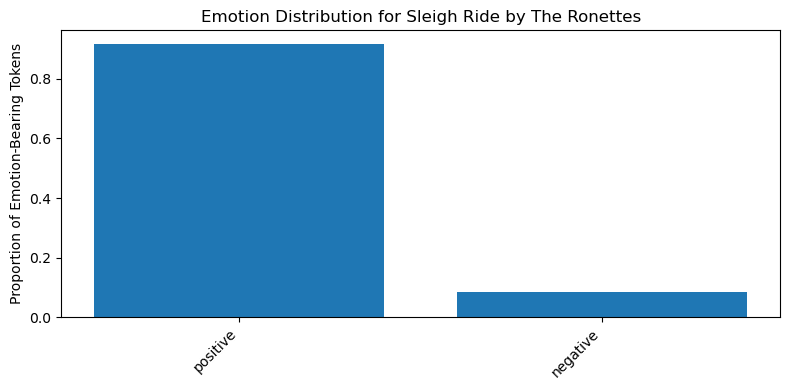

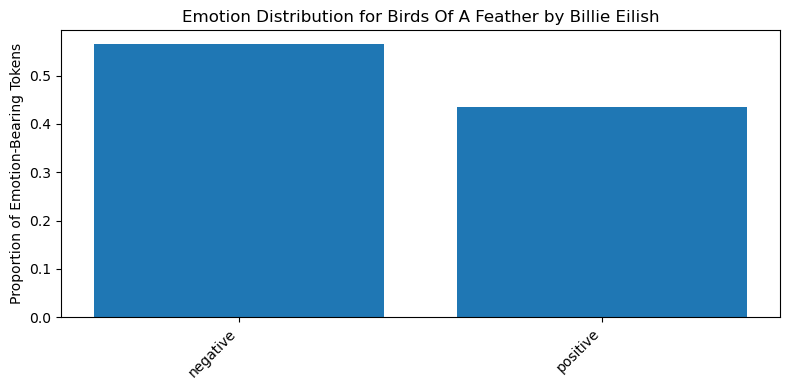

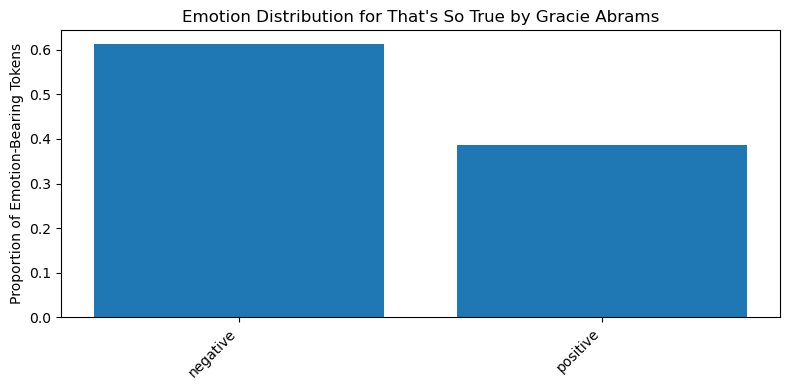

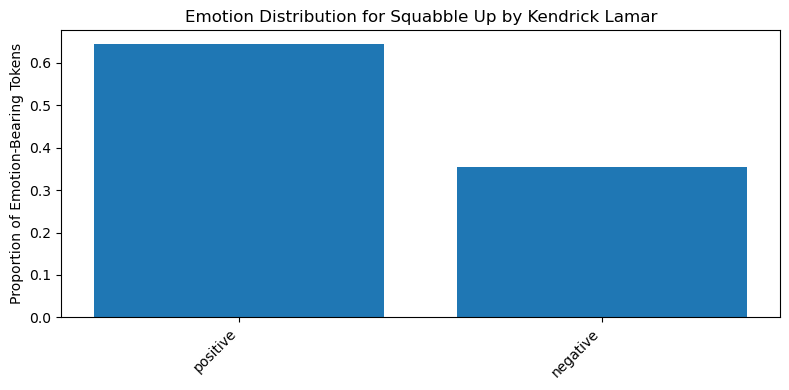

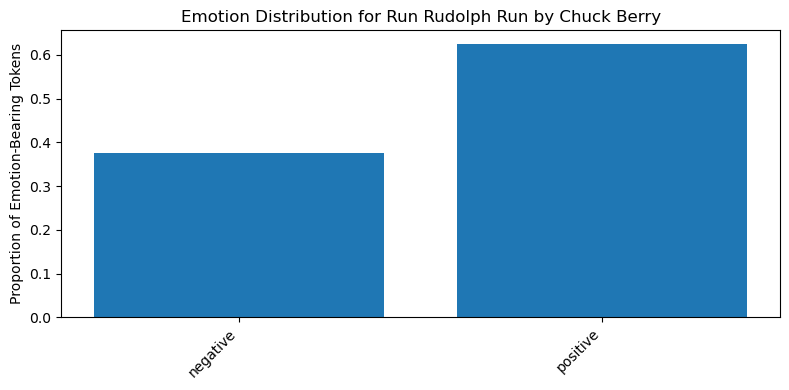

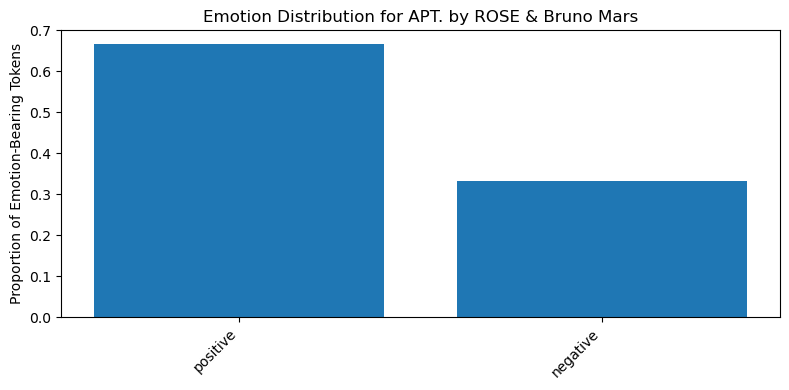

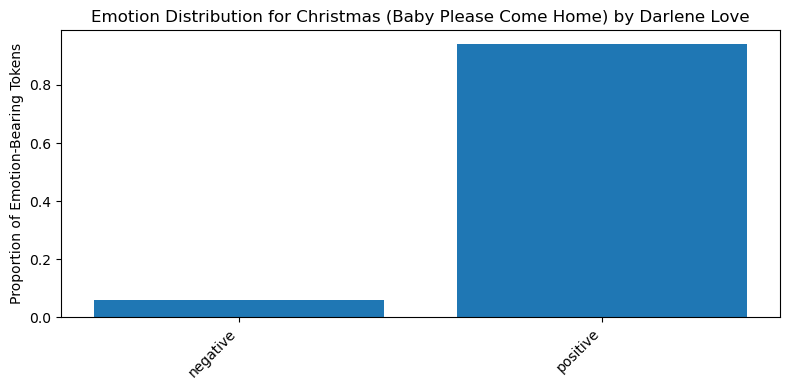

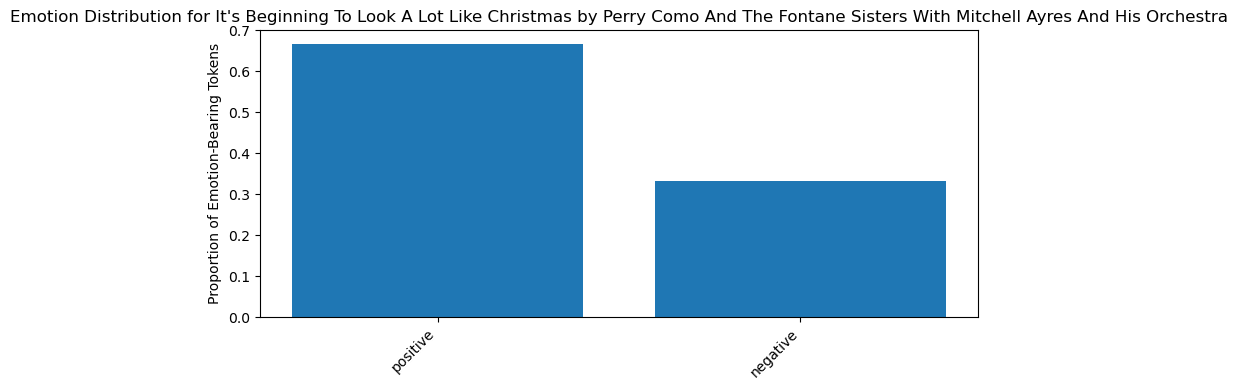

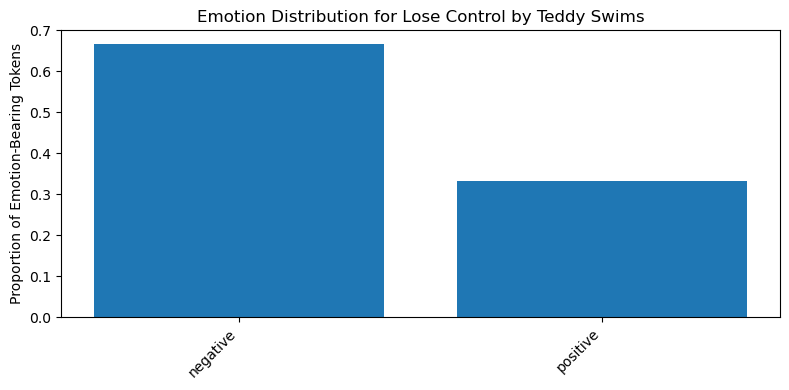

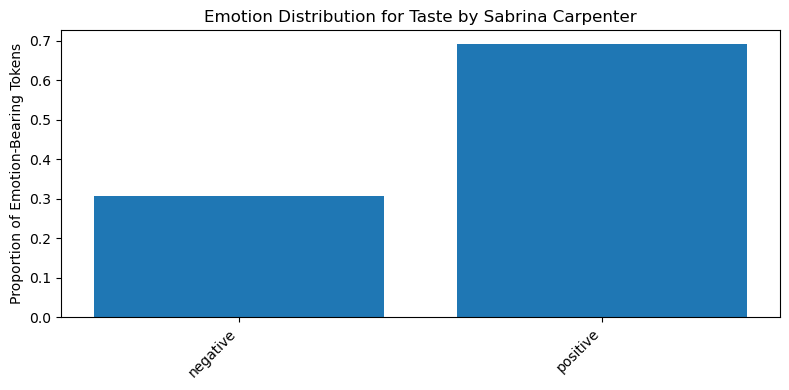

In [13]:
for idx, row in df.iterrows():

    if idx > 25: break
    
    emotions = row['sentiment']
    keys = list(emotions.keys())
    values = [emotions[e] for e in keys]

    plt.figure(figsize=(8, 4))
    plt.bar(keys, values)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Proportion of Emotion-Bearing Tokens")
    plt.title(f"Emotion Distribution for {row['title']} by {row['artist']}")
    plt.tight_layout()
    plt.show()

## Does Emotion Affect Success?

Let's look at each emotion and try to find a correlation between the weight of this emotion in a song, and the songs' success within the billboard charts.

In [14]:
full_df = pd.read_excel("../data/processed/dataset.xlsx")

Let's create a df for this analysis

In [16]:
songs = pd.DataFrame()
songs[["title", "artist", "song_id"]] = df[["title", "artist", "song_id"]]

# Compute the top rank for each song in the billboard for that year:
min_ranks = full_df.groupby('song_id')['rank'].min()
songs['top_rank'] = songs['song_id'].map(min_ranks)

# Compute how many times each song appeared in the billboard that year
counts = full_df['song_id'].value_counts()    #    This is a Series whose index is song_id and whose values are the counts.
songs['weeks'] = songs['song_id'].map(counts).fillna(0).astype(int)

# Add emotions
emotion_keys = ["anger","anticipation","disgust","fear","joy","sadness","surprise","trust"]
emotions_df = df['emotions'].apply(pd.Series)
songs = pd.concat([songs, emotions_df], axis=1)

# Add sentiment
sentiment_keys = ["positive","negative"]
sentiment_df = df["sentiment"].apply(pd.Series)
songs = pd.concat([songs, sentiment_df], axis=1)

In [17]:
songs

,title,artist,song_id,top_rank,weeks,anticipation,joy,surprise,trust,anger,disgust,fear,sadness,positive,negative
0,All I Want For Christmas Is You,Mariah Carey,all_i_want_for_christmas_is_you__mariah_carey,1,6,0.160000,0.440000,0.120000,0.200000,0.040000,0.040000,NaN,NaN,0.958333,0.041667
1,Rockin' Around The Christmas Tree,Brenda Lee,rockin_around_the_christmas_tree__brenda_lee,1,6,0.192308,0.211538,0.115385,0.173077,0.115385,0.115385,0.038462,0.038462,0.875000,0.125000
2,Last Christmas,Wham!,last_christmas__wham,3,7,0.047619,0.230159,0.031746,0.103175,0.126984,0.150794,0.174603,0.134921,0.584906,0.415094
3,Jingle Bell Rock,Bobby Helms,jingle_bell_rock__bobby_helms,3,5,0.812500,0.062500,NaN,0.125000,NaN,NaN,NaN,NaN,1.000000,NaN
4,A Holly Jolly Christmas,Burl Ives,a_holly_jolly_christmas__burl_ives,5,6,0.300000,0.233333,0.166667,0.166667,NaN,NaN,0.066667,0.066667,0.636364,0.363636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,I Saw Mommy Kissing Santa Claus,Jackson 5,i_saw_mommy_kissing_santa_claus__jackson_5,43,1,0.268293,0.341463,0.292683,0.097561,NaN,NaN,NaN,NaN,0.933333,0.066667
754,Merry Christmas,Ed Sheeran & Elton John,merry_christmas__ed_sheeran__elton_john,46,1,0.230769,0.355769,0.086538,0.182692,0.019231,0.009615,0.076923,0.038462,0.926829,0.073171
755,(There's No Place Like) Home For The Holidays ...,Perry Como With Mitchell Ayers And His Orchestra,theres_no_place_like_home_for_the_holidays_195...,50,1,0.321429,0.357143,0.107143,0.142857,NaN,NaN,NaN,0.071429,0.916667,0.083333
756,Winter Wonderland,Chloe,winter_wonderland__chloe,87,1,0.218750,0.281250,0.093750,0.093750,0.031250,0.062500,0.156250,0.062500,0.777778,0.222222


### Calculating Pearson correlation (emotion/sentiment vs. success metric)

Our success metrics are:
1. top rank (this year)
2. weeks on chart (this year)

In [25]:
# Pearson correlation
feeling_metric = emotion_keys + sentiment_keys
subset = songs[feeling_metric + metrics]
corr_matrix = subset.corr(method='pearson')
pearson_results = corr_matrix.loc[feeling_metric, metrics].round(3)

print("Pearson correlations (emotions vs. metrics):")
print(pearson_results)

Pearson correlations (emotions vs. metrics):
              weeks  top_rank
anger        -0.004     0.011
anticipation -0.062    -0.012
disgust      -0.021     0.083
fear         -0.040    -0.029
joy           0.030    -0.030
sadness      -0.009     0.040
surprise      0.091    -0.040
trust        -0.056    -0.042
positive     -0.023    -0.043
negative      0.009     0.036


**We can determine by that that there is no correlation between the sentiment or emotion of a song and it's success on the billboard.**

Below is a visualization:

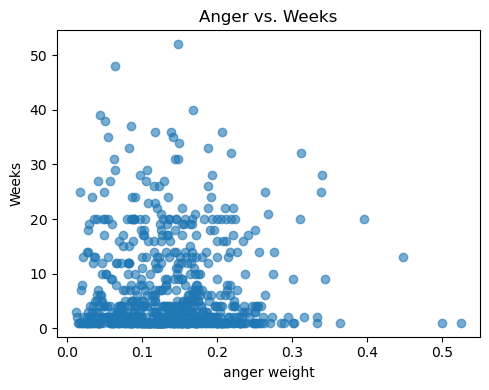

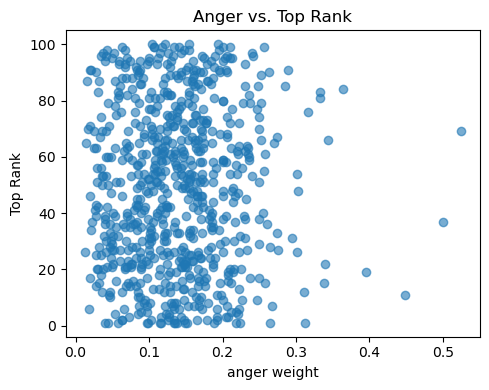

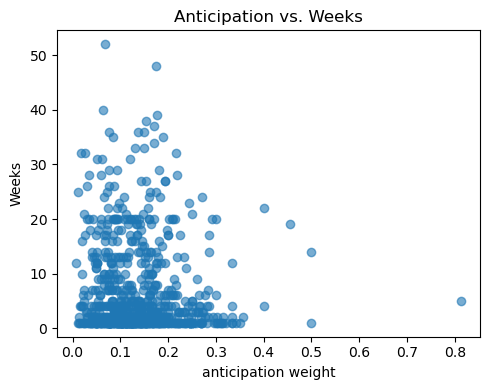

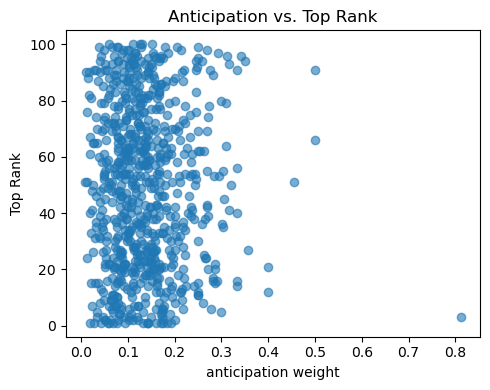

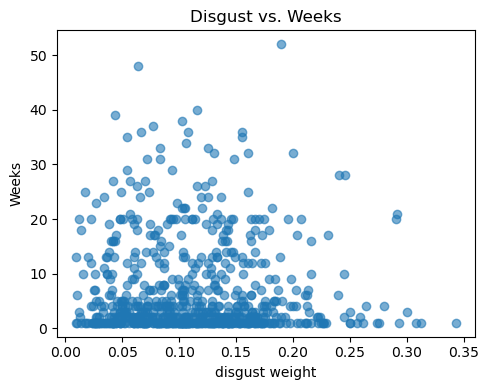

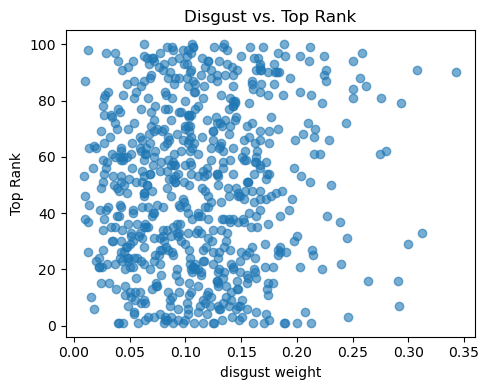

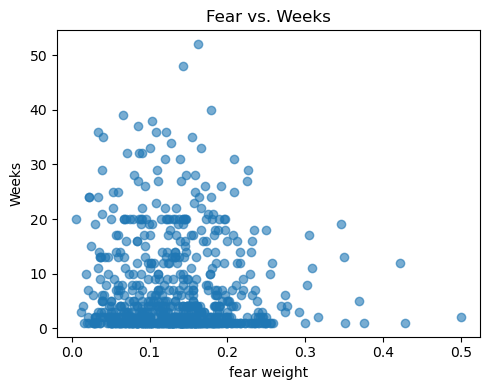

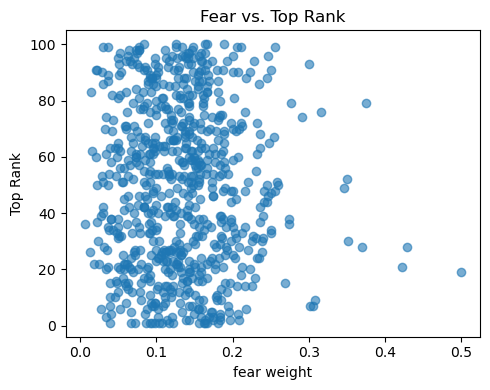

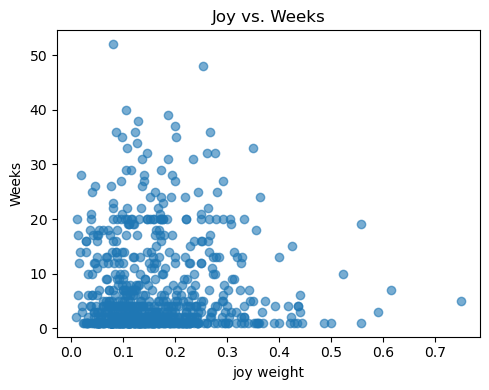

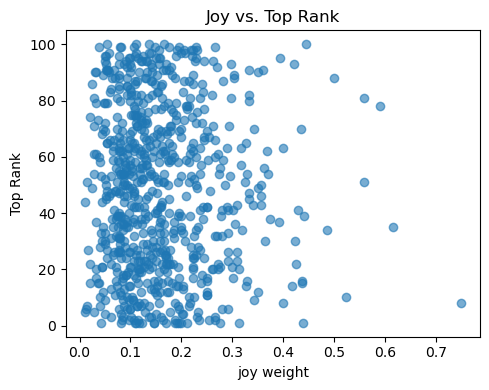

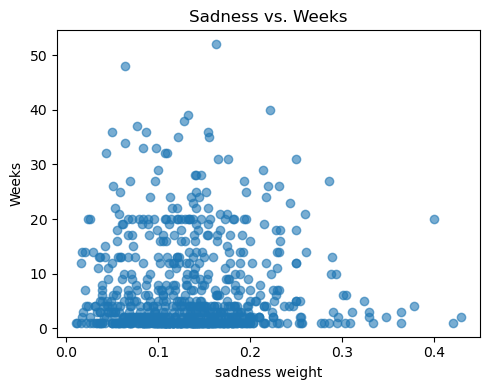

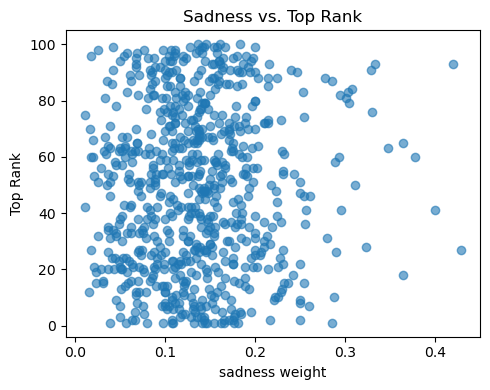

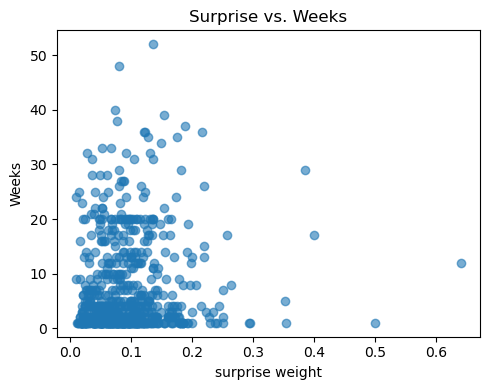

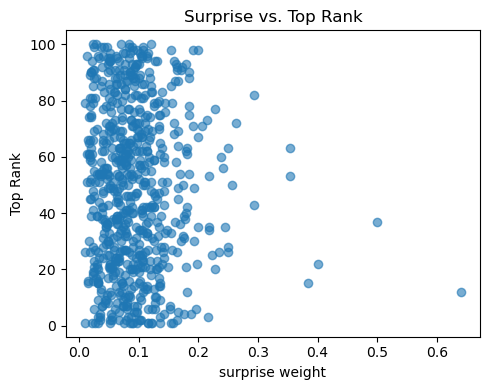

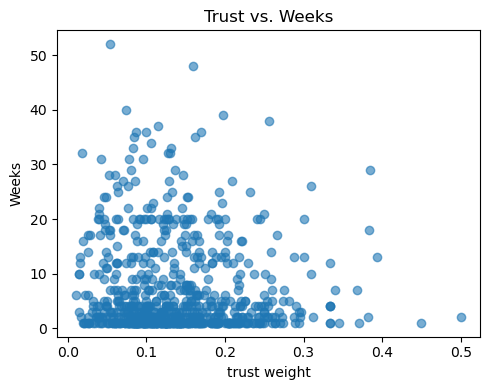

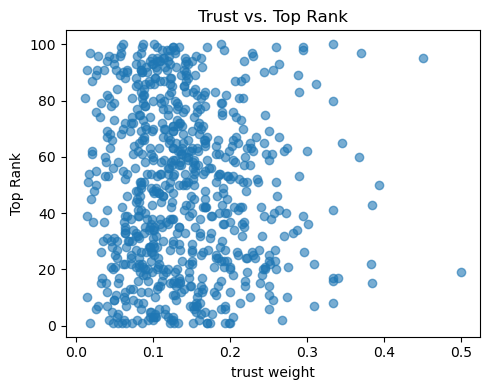

In [18]:
metrics = ['weeks', 'top_rank']

# Loop over every combination of emotion and metric,
# creating a separate scatter plot for each.
for emotion in emotion_keys:
    for metric in metrics:
        plt.figure(figsize=(5, 4))
        plt.scatter(songs[emotion], songs[metric], alpha=0.6)
        plt.xlabel(f"{emotion} weight")
        # Turn 'top_rank' into 'Top Rank' for axis labeling
        plt.ylabel(metric.replace('_', ' ').title())
        plt.title(f"{emotion.capitalize()} vs. {metric.replace('_', ' ').title()}")
        plt.tight_layout()
        plt.show()


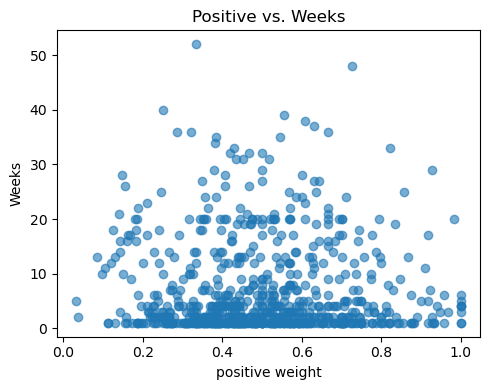

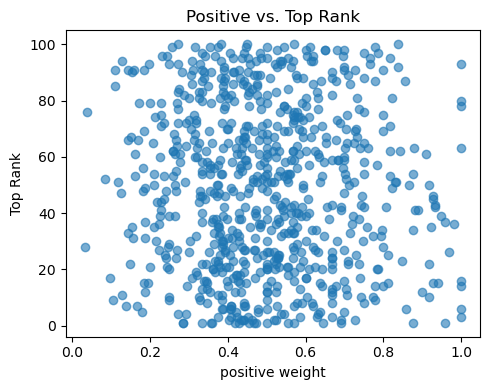

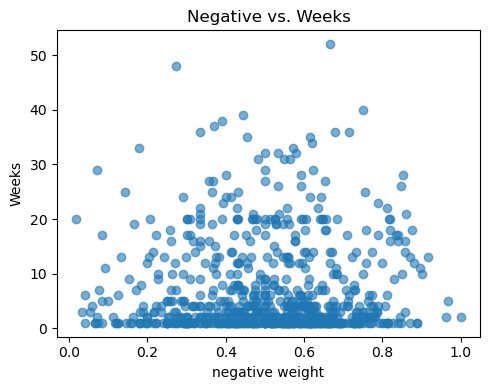

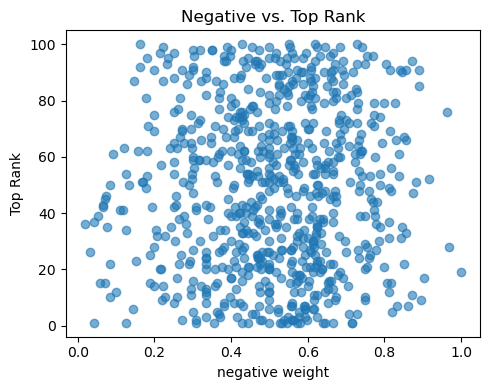

In [20]:
metrics = ['weeks', 'top_rank']

# Loop over every combination of emotion and metric,
# creating a separate scatter plot for each.
for sentiment in sentiment_keys:
    for metric in metrics:
        plt.figure(figsize=(5, 4))
        plt.scatter(songs[sentiment], songs[metric], alpha=0.6)
        plt.xlabel(f"{sentiment} weight")
        # Turn 'top_rank' into 'Top Rank' for axis labeling
        plt.ylabel(metric.replace('_', ' ').title())
        plt.title(f"{sentiment.capitalize()} vs. {metric.replace('_', ' ').title()}")
        plt.tight_layout()
        plt.show()
